In [38]:
import pandas as pd
import numpy as np
import quandl
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

In [39]:
register_matplotlib_converters()

           Date       Close
2544 2020-09-18  200.389999
2545 2020-09-21  202.539993
2546 2020-09-22  207.419998
2547 2020-09-23  200.589996
2548 2020-09-24  203.190002


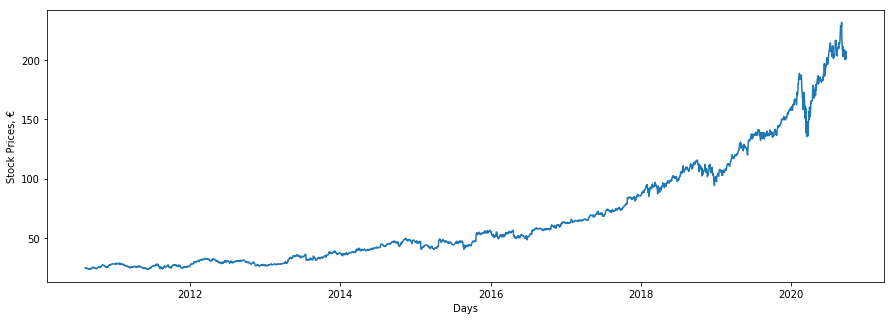

In [40]:
# Plot of E.ON(a big scale energy company in Europe)

#Using scikit - different article - instead of quandl
start = datetime.datetime(2010,8,11)
end = datetime.datetime(2020,9,24)
prices = web.DataReader("MSFT", 'yahoo', start, end).reset_index(drop = False)[['Date', 'Close']]

print(prices.tail())
plt.figure(figsize = (15, 5))
plt.plot(prices['Date'], prices['Close'])
plt.xlabel('Days')
plt.ylabel('Stock Prices, €')
plt.show()

In [41]:
#--------------------------------------------------- GEOMETRIC BROWNIAN MOTION ------------------------------------------------

# Parameter Definitions

# So    :   initial stock price
# dt    :   time increment -> a day in our case
# T     :   length of the prediction time horizon(how many time points to predict, same unit with dt(days))
# N     :   number of time points in prediction the time horizon -> T/dt
# t     :   array for time points in the prediction time horizon [1, 2, 3, .. , N]
# mu    :   mean of historical daily returns
# sigma :   standard deviation of historical daily returns
# b     :   array for brownian increments
# W     :   array for brownian path

start_date = '2010-08-11'
end_date = '2020-09-24'
pred_end_date = '2020-10-24'

#Using scikit - different article
#Change S_eon name
start = datetime.datetime(2010,8,11)
end = datetime.datetime(2020,9,24)
S_eon = web.DataReader("MSFT", 'yahoo', start, end).reset_index(drop = False)[['Date', 'Close']]
print(type(S_eon))

print(S_eon.head())
print(S_eon.tail())


<class 'pandas.core.frame.DataFrame'>
        Date      Close
0 2010-08-11  24.860001
1 2010-08-12  24.490000
2 2010-08-13  24.400000
3 2010-08-16  24.500000
4 2010-08-17  24.709999
           Date       Close
2544 2020-09-18  200.389999
2545 2020-09-21  202.539993
2546 2020-09-22  207.419998
2547 2020-09-23  200.589996
2548 2020-09-24  203.190002


In [42]:
returns = (S_eon.loc[1:, 'Close'] - \
           S_eon.shift(1).loc[1:, 'Close']) / \
           S_eon.shift(1).loc[1:, 'Close']
print(returns.tolist())

[-0.014883380134726634, -0.0036749756402215516, 0.004098376353816929, 0.00857139120296556, 0.004451663878072947, -0.015310200057973563, -0.008592511752552894, 0.0020636048433274046, -0.00988466904163511, 0.002495817955798387, -0.011618285569024216, 0.004617993776694473, -0.012118717585833876, -0.00719120476662895, 0.018321274723306444, 0.0016736785006611478, 0.01461989864920043, -0.0135859126643233, -0.001252035911650589, 0.0033430807641382115, -0.006663883627108182, 0.05283019743097338, -0.0031859785647745, 0.003595691175346601, 0.00835983588601922, -0.004342700777058203, 0.008326764375052514, -0.011010644250307742, -0.021471133851661967, -0.007314112178447844, 0.01432666300031011, -0.0020178023819073746, -0.0020218050135889917, -0.007293367218396362, -0.000408172607421875, -0.004491654200882832, -0.019278069299970953, 0.018402364569870145, 0.003285417759867239, 0.004093343439236074, 0.0016306158605403948, 0.0008140194551115547, 0.009760055698613166, 0.020539679035396257, -0.004340986

In [73]:
# Parameter Assignments
So = S_eon.loc[S_eon.shape[0] - 1, "Close"]
dt = 1 # day   # User input
n_of_wkdays = pd.date_range(start = pd.to_datetime(end_date, 
                 format = "%Y-%m-%d") + pd.Timedelta('1 days'), 
                 end = pd.to_datetime(pred_end_date, 
                 format = "%Y-%m-%d")).to_series().map(lambda x: 
                 1 if x.isoweekday() in range(1,6) else 0).sum()
T = n_of_wkdays # days  # User input -> follows from pred_end_date
N = T / dt
t = np.arange(1, int(N) + 1)
mu = np.mean(returns)
sigma = np.std(returns)
scen_size = 50 # User input
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}


In [74]:
# Calculating drift and diffusion components
drift = (mu - 0.5 * sigma**2) * t
print(drift)
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}
print(diffusion)

[0.00082487 0.00164974 0.0024746  0.00329947 0.00412434 0.00494921
 0.00577407 0.00659894 0.00742381 0.00824868 0.00907355 0.00989841
 0.01072328 0.01154815 0.01237302 0.01319788 0.01402275 0.01484762
 0.01567249 0.01649736 0.01732222]
{'1': array([ 2.25886200e-02,  2.82279767e-02,  2.63664318e-02,  1.91403413e-02,
       -1.31625266e-03, -6.71975293e-06, -4.85870348e-03,  1.97109345e-03,
       -7.52328955e-04, -2.86950963e-02, -1.74834841e-02, -1.90899726e-02,
       -1.39272519e-02, -2.52483143e-02, -1.76421913e-02, -3.52676951e-02,
       -4.85598718e-02, -3.51184395e-02, -3.07310545e-02, -6.55879513e-02,
       -3.93099069e-02]), '2': array([ 0.01021668,  0.0021806 ,  0.00681979, -0.01031713, -0.04832676,
       -0.04564386, -0.05117717, -0.07323412, -0.0803888 , -0.05959857,
       -0.09113043, -0.09161675, -0.08571678, -0.05862965, -0.04126183,
       -0.02022765, -0.03310937, -0.04244201, -0.0670362 , -0.0703736 ,
       -0.06999066]), '3': array([0.00144082, 0.01124001, 0.0220

In [75]:
# Making the predictions
S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]) 
S = np.hstack((np.array([[So] for scen in range(scen_size)]), S)) # add So to the beginning series


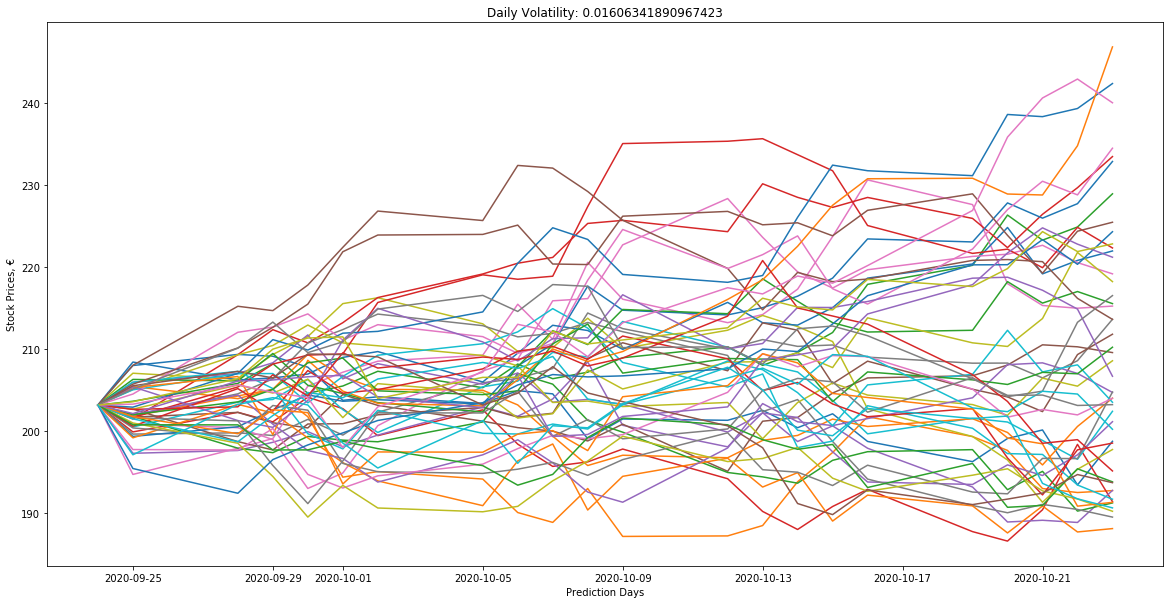

In [76]:
# Plotting the simulations
plt.figure(figsize = (20,10))
for i in range(scen_size):
    plt.title("Daily Volatility: " + str(sigma))
    plt.plot(pd.date_range(start = S_eon["Date"].max(), 
                end = pred_end_date, freq = 'D').map(lambda x:
                x if x.isoweekday() in range(1, 6) else np.nan).dropna(), S[i, :])
    plt.ylabel('Stock Prices, €')
    plt.xlabel('Prediction Days')
plt.show()

In [77]:
# Dataframe format for predictions - first 10 scenarios only
Preds_df = pd.DataFrame(S.swapaxes(0, 1)[:, :10]).set_index(
           pd.date_range(start = S_eon["Date"].max(), 
           end = pred_end_date, freq = 'D').map(lambda x:
           x if x.isoweekday() in range(1, 6) else np.nan).dropna()
           ).reset_index(drop = False)
print(Preds_df)

        index           0           1           2           3           4  \
0  2020-09-24  203.190002  203.190002  203.190002  203.190002  203.190002   
1  2020-09-25  208.003520  205.445967  203.650889  199.914110  197.311760   
2  2020-09-28  209.352456  203.969780  205.826021  202.301266  197.650626   
3  2020-09-29  209.135538  205.087333  208.232906  201.145760  198.651117   
4  2020-09-30  207.801090  201.769076  204.621807  204.146530  199.947881   
5  2020-10-01  203.761379  194.404122  205.507154  202.748581  198.113101   
6  2020-10-02  204.196752  195.087244  207.301027  199.460980  199.530572   
7  2020-10-05  203.376082  194.170845  205.302282  202.606108  202.958942   
8  2020-10-06  204.938831  190.091651  208.184367  198.425572  201.819563   
9  2020-10-07  204.550113  188.892208  206.396321  195.713711  203.930729   
10 2020-10-08  199.077679  193.019578  207.190112  196.260403  208.439345   
11 2020-10-09  201.488352  187.182604  208.951472  197.827624  200.717806   

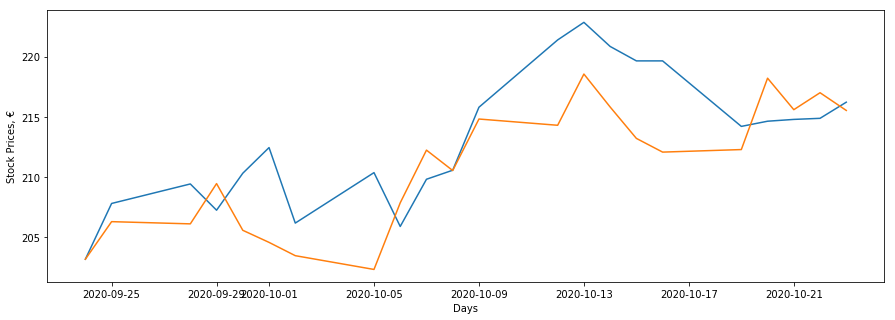

In [81]:
#Test against actual graph
#Using scikit - different article - instead of quandl
start = datetime.datetime(2020,9,24)
end = datetime.datetime(2020,10,24)
prices = web.DataReader("MSFT", 'yahoo', start, end).reset_index(drop = False)[['Date', 'Close']]

plt.figure(figsize = (15, 5))
plt.plot(prices['Date'], prices['Close'])
plt.plot(prices['Date'], S[22])
plt.xlabel('Days')
plt.ylabel('Stock Prices, €')
plt.show()

In [79]:
def compute_differences(pred, actual):
    sum = 0
    for i in range(len(actual)):
        temp_min = abs(pred[i] - actual[i])
        sum += temp_min
    return sum

In [80]:
min_sum = 10000000
actual_array = prices.loc[:, 'Close']
index = -1
for i in range(len(S)):
    sum = compute_differences(S[i], actual_array)
    if(sum < min_sum):
        min_sum = sum
        index = i
        print(index)
print("Index to check is " + str(index))

0
2
6
10
22
Index to check is 22


In [51]:
def maxProfit (k, prices):
    # corner case
    if prices is None or len(prices) == 0: return 0
    # if k is too large, to save space, we can directly sum up profit pair by pair
    if 2*k >= len(prices): 
        return sum(max(0, prices[i]-prices[i-1]) for i in range(1, len(prices)))

    # optimized DP solution in problem III by using two rows instead of a matrix 
    n = len(prices)
    no_of_transaction = 0
    currProfit = [0 for _ in range(n)]
    prevProfit = [0 for _ in range(n)]
    for i in range(1, k+1):
        maxdiff = -prices[0]
        # assign currProfit array [last loop] to prevProfit array [this loop]
        # 1. also create an new currProfit array for futher use [easy to understand] 
        currProfit, prevProfit = [0 for _ in range(n)], currProfit
        # 2. assign prevProfit array to currprofit since currProfit[0] is still zero, which is enough here [Faster way] 
        # currProfit, prevProfit = prevProfit, currProfit
        for j in range(1, n):
            currProfit[j] = max(currProfit[j-1], prices[j]+maxdiff)
            maxdiff = max(maxdiff, prevProfit[j]-prices[j])  
        print(str(currProfit[-1]))
    # return the result
    return currProfit[-1]

In [52]:
max_profit = 0
for i in range(len(S)):
    max_profit = max(max_profit, maxProfit(10, S[i]))
    
print(max_profit)

12.24083477682592
16.567542223764235
20.847378145889337
23.205544045127084
25.286153890535502
26.47667653164234
26.47667653164234
26.47667653164234
26.47667653164234
26.47667653164234
15.422523772191937
23.54671942058374
29.86765809686483
31.505929003838276
31.505929003838276
31.505929003838276
31.505929003838276
31.505929003838276
31.505929003838276
31.505929003838276
8.914985629619025
15.311863221683154
19.025853788010636
20.005722895929296
20.37017431364245
20.37017431364245
20.37017431364245
20.37017431364245
20.37017431364245
20.37017431364245
11.243939599639276
15.187805413769695
17.54826619734115
19.805418743616457
21.94099135913916
23.389145076064608
23.755526814457568
23.755526814457568
23.755526814457568
23.755526814457568
14.699101293837913
24.75654085051704
29.576832168854992
33.85618189481923
37.17407274768405
39.571502960304514
39.571502960304514
39.571502960304514
39.571502960304514
39.571502960304514
37.36013935626423
41.784783914033824
43.86617839702677
45.512090368778

In [53]:
def single_profit(kind, prices):
    n = len(prices)
    if n == 0:
        return 0
    temp = 0
    result = 0
    tempSell = 0
    maxPrice = prices[n - 1]
    
    buyDates = []
    sellDates = []
    buy_date = 0
    sell_date = 0
    
    for i in range(n-2, -1, -1):
        if prices[i] < maxPrice:
            result = max(result, maxPrice- prices[i])
            if result != temp:
                buyDates.append(i)
            temp = result
        
        maxPrice = max(maxPrice, prices[i])
        if maxPrice != tempSell:
            sellDates.append(i)
        tempSell = maxPrice
    
    if len(buyDates) > 0:
        buy_date = buyDates[len(buyDates) - 1]
    
    if len(sellDates) > 0:
        i = 1
        if kind == "max":
            if sellDates[len(sellDates) - 1] < buyDates[len(buyDates) - 1]:
                sell_date = sellDates[len(sellDates) - 2]
            else:
                sell_date = sellDates[len(sellDates) - 1]
        else:
            while sellDates[len(sellDates) - i] < buyDates[len(buyDates) - 1]:
                sell_date = sellDates[len(sellDates) - i - 1]
                i = i + 1
    
    return result, buy_date, sell_date


In [54]:
max_profit = 0
buy_date = 0
sell_date = 0
min_profit = 100000000000

#Best case scenario
for i in range(len(S)):
    temp_profit, temp_buy, temp_sell = single_profit("max", S[i])
#     max_profit = max(max_profit, single_profit(S[i]))
    if(temp_profit > max_profit):
        max_profit = temp_profit
        buy_date = temp_buy
        sell_date = temp_sell
    
print(max_profit)
print("Buy on " + str(buy_date))
print("Sell on " + str(sell_date))

#Worst case scenario
for i in range(len(S)):
    temp_profit, temp_buy, temp_sell = single_profit("min", S[i])
#     max_profit = max(max_profit, single_profit(S[i]))
    if(temp_profit < min_profit):
        min_profit = temp_profit
        buy_date = temp_buy
        sell_date = temp_sell
        
print(min_profit)
print("Buy on " + str(buy_date))
print("Sell on " + str(sell_date))


37.6105150086122
Buy on 2
Sell on 15
2.682941755185311
Buy on 9
Sell on 11
